# BME 인공지능 - Homework #4
### 202001269 라현아

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
path_train = '/content/drive/MyDrive/rsna2019/train'
path_valid = '/content/drive/MyDrive/rsna2019/valid'

### Image Data Loader 생성 
- pytorch에서는 image data를 편하게 가져올 수 있는 다양한 도구들을 제공합니다.
- ImageFolder는 그 중 하나로, image data를 폴더별로 정리한 경우 자동으로 폴더이름을 label로 하여 loader를 정의합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 32

train_transforms = transforms.Compose(
      [
          transforms.Grayscale(num_output_channels=1),
          transforms.Resize((64,64)),
          transforms.ToTensor(),
      ]
    )

trainset = torchvision.datasets.ImageFolder(root = path_train,transform=train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=train_transforms)

train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)

In [ ]:
tgtnames = trainset.classes
tgtnames

['covid19', 'normal', 'opacity']

torch.Size([32])
torch.Size([32, 1, 64, 64])


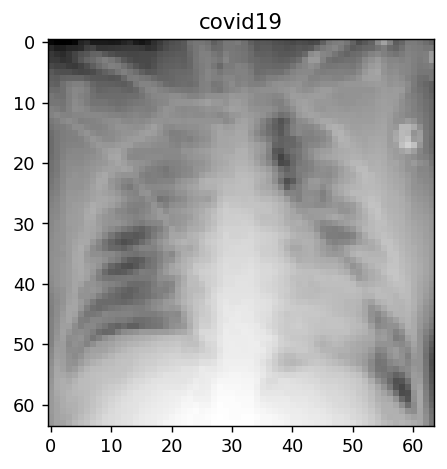

In [ ]:
dataiter=iter(train_iter)
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)
I = images[0][0].numpy()
plt.figure(dpi=128)
plt.imshow(I,cmap='gray')
plt.title(tgtnames[labels[0]])
plt.show()
#print(labels[0])


### Model 정의하기
- LeNet5와 비슷한 구조의 CNN을 pytorch을 이용하여 구현해 봅시다.

In [ ]:
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    # 6 x 64 x 64
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    # 6 x 32 x 32
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    # no padding => 양쪽 2만큼 줄어듦 => 16 x 28 x 28
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    # 16 x 14 x 14
    nn.Flatten(),
    nn.Linear(in_features=16*14*14, out_features=120),
    # input size에 따라 in_features에 들어가는 숫자가 달라짐에 유의
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 3)#nn.Linear(84, 2)
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=3, bias=True)
)

### CNN model 불러오기
- PyTorch에서 이미 구현되어 있는 유명한 CNN model을 불러와서 내 문제에 맞게 input layer와 output layer를 수정하여 사용해 봅시다.
- PyTorch에서 구현되어 있는 model들을 아래에서 확인해 봅니다.
  - https://pytorch.org/vision/stable/models.html#classification
  

In [ ]:
import torchvision.models as models

In [ ]:
net = models.resnext50_32x4d()
#net = models.resnet18() # 높은 정확도
#alexnet = models.alexnet() # 다소 높은 정확도
#vgg16 = models.vgg16() # 높은 정확도가 나오긴 했지만 빈도가 낮음
#squeezenet = models.squeezenet1_0() # 낮은 정확도
#densenet = models.densenet161() ## 78 찍음
#inception = models.inception_v3() # Given input size: (768x2x2). Calculated output size: (768x0x0). Output size is too small
#googlenet = models.googlenet() # 'GoogLeNetOutputs' object has no attribute 'argmax'
#shufflenet = models.shufflenet_v2_x1_0() # 낮은 정확도
#mobilenet = models.mobilenet_v2() # 높은 정확도
#resnext50_32x4d = models.resnext50_32x4d() # 높은 정확도, 적은 epoch로도 도달함
#wide_resnet50_2 = models.wide_resnet50_2() # 높은 정확도, resnext50_32x4d() 보다 적은 epoch로도 도달함, 하지만 시간은 좀 더 걸림
#mnasnet = models.mnasnet1_0()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc = torch.nn. Linear(in_features=2048, out_features=3, bias=True)
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

### Hyperparameter 설정하기

In [ ]:
# setting hyper-parameters
learning_rate = 0.08
num_epochs = 25

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

### Model 학습시키기

In [ ]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs+1):
    i=0
    l_epoch = 0
    correct = 0
    net.train()
    for X,y in train_iter:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=net(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    net.eval()
    for X,y in valid_iter:
        X,y = X.to(device),y.to(device)
        y_hat = net(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')
#        plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  9.536157708418997
train accuracy:  0.34416666626930237
valid accuracy:  0.34333333373069763
epoch: 5 
train loss:  0.9579867312782689
train accuracy:  0.6549999713897705
valid accuracy:  0.70333331823349
epoch: 10 
train loss:  0.6669985620599044
train accuracy:  0.8183333277702332
valid accuracy:  0.7866666913032532
epoch: 15 
train loss:  0.5103630266691509
train accuracy:  0.8500000238418579
valid accuracy:  0.8899999856948853
epoch: 20 
train loss:  0.20047488965486226
train accuracy:  0.9375
valid accuracy:  0.8133333325386047
epoch: 25 
train loss:  0.16022446281031558
train accuracy:  0.9574999809265137
valid accuracy:  0.9100000262260437


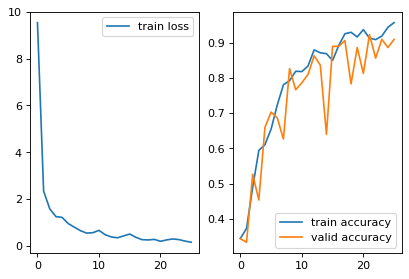

In [ ]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()

### Validation set 결과 확인

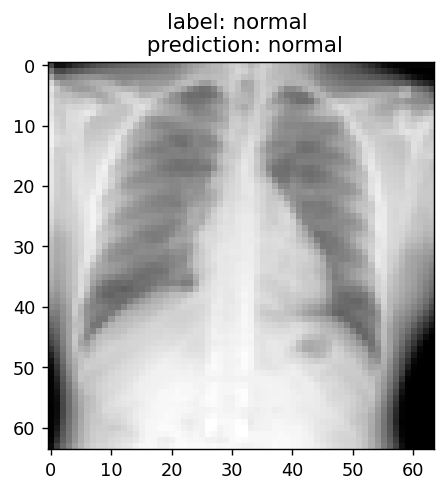

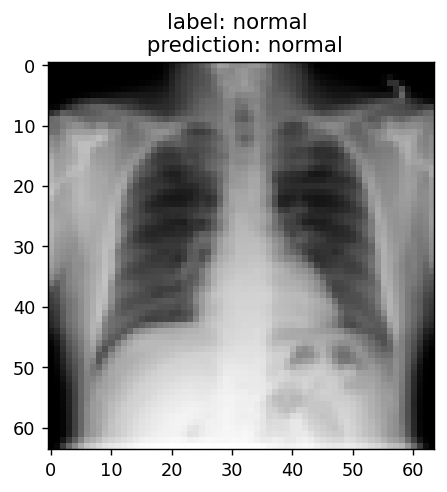

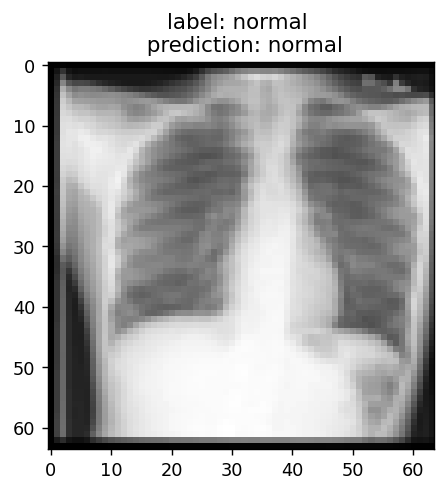

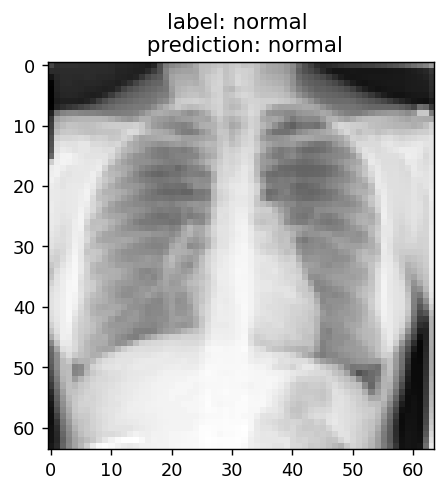

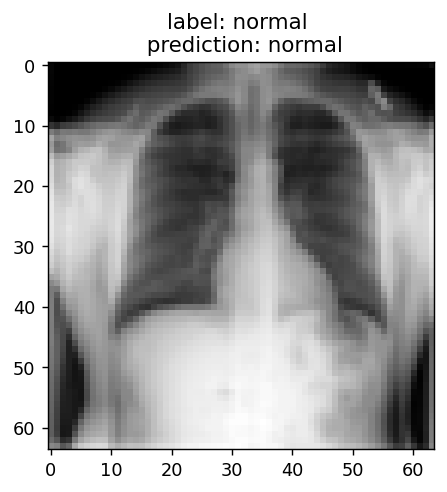

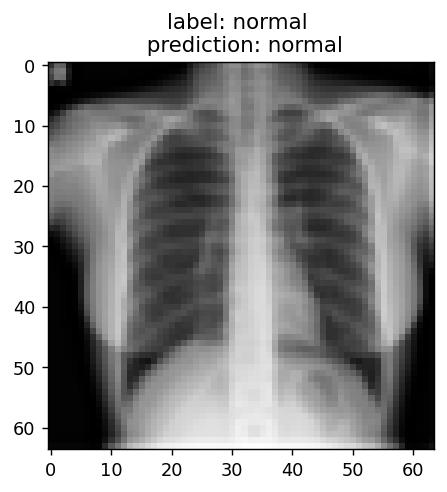

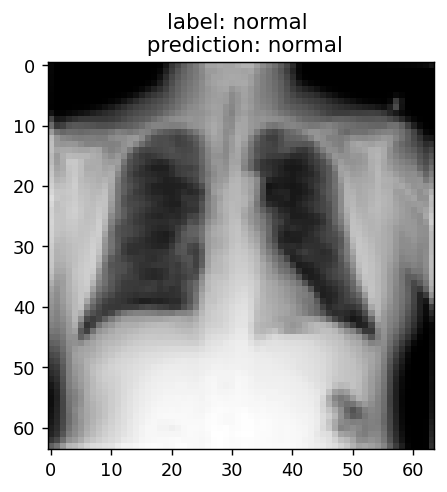

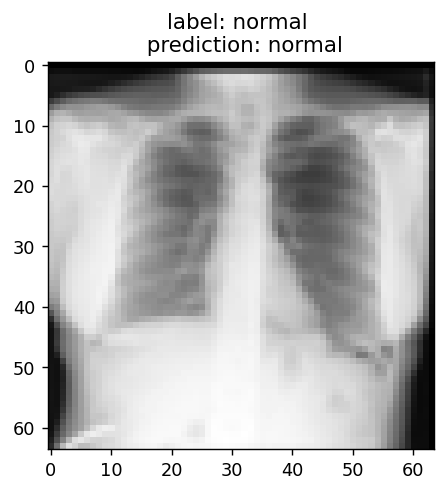

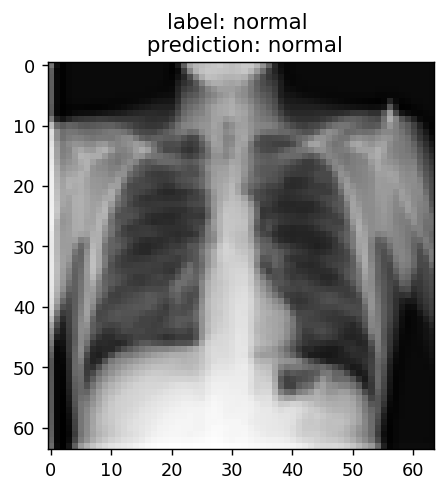

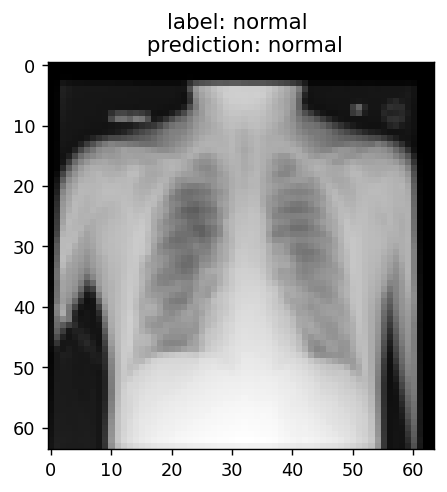

In [ ]:
i = 0
y_list = np.array([])
y_hat_list = np.array([])
for X,y in valid_iter:
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)

  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

  if i == 5:
    for n in range(i,i+10):
      plt.figure(dpi=128)
      plt.imshow(X[n].cpu().squeeze(),cmap='gray')
      plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
      plt.pause(.0001)
  i=i+1



In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

              precision    recall  f1-score   support

     covid19       1.00      0.73      0.84       100
      normal       0.93      1.00      0.96       100
     opacity       0.84      1.00      0.91       100

    accuracy                           0.91       300
   macro avg       0.92      0.91      0.91       300
weighted avg       0.92      0.91      0.91       300



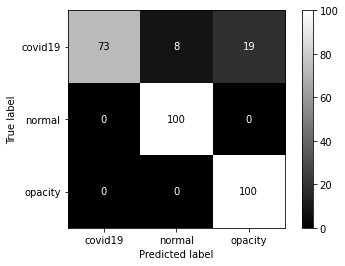

In [ ]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1],cmap='gray')

# **<결과>**

**1. 최종적으로 사용한 CNN model**
- resnext50_32x4d()

**2. 최종적으로 사용한 하이퍼파라미터들(batch_size, lr, num_epochs 등)의 값들**
   - batch_size = 32
   - learning_rate = 0.08
   - num_epochs = 25

**3. 학습과정을 요약하는 epoch에 따른 train loss curve 및 train set과 valid set 각각의 accuracy curve**
<img src="https://drive.google.com/uc?id=1lr1mB7TrJOwzrAXOWqplMnWO2ER9axxJ">

**4. valid set(각 100장, 총 300장)에 대한 confusion matrix**

<img src="https://drive.google.com/uc?id=16jw__R6TfmA8QrPQya9DNOVrt_jYE_mw">

**5. valid set(각 100장, 총 300장)의 각 class별로 틀린 예측을 한 data들에 대해 해당하는 image를 관찰하여, class별 accuracy의 차이가 있는 경우 그 이유를 분석**

  : covid(100%) > normal(93%) > opacity(84%) class 순으로 정확도가 높았습니다. 이러한 차이는 세 class의 특성에 의해 발생했다고 생각합니다. covid나 normal class는 명확한 특징이 있지만, opacity의 경우 covid와 normal의 특징을 모두 가지고 있거나 노이즈가 심한 데이터가 대부분이기 때문에 잘못 분석될 경우 covid나 normal로 판별될 가능성을 내포하고 있어 가장 낮은 정확도를 얻었다고 생각합니다. normal의 경우에도, 명확한 특징이 있기는 하지만 노이즈가 있을 경우 노이즈가 covid의 특징으로 간주 될 수 있어 covid보다 낮은 정확도를 얻었을 것이라고 생각합니다.
  
  다음은 틀리게 예측된 데이터들을 관찰한 결과입니다.

 - opacity -> covid : 전체적으로 뿌옇고 경계가 확실하지 않음, ground glass 처럼 보이는 부분 있음
 - opacity -> normal : 전체적으로 뿌옇지만 횡경막과 폐의 경계가 확실, 또는 회색 부분이 거의 없이 흑색과 백색의 경계가 확실, 연결된 호스가 함꼐 찍힘

 - covid -> normal : ground glass 처럼 보이는 부분 없는 경우
 - covid -> opacity: 지나치게 압축된 사진, 뿌연 정도가 아니라 하얀 사진

 - normal -> covid : ground glass 처럼 보이는 뭉텅이가 있는 경우
 - normal -> opacity : 지나치게 압축된 사진, 뿌연 정도가 아니라 하얀 사진